In [1]:
'''
ResNet-50 Architecture
+----------+------------------+--------------------------------+------------------+
| Layer    | Type             | Configuration                  | Output Size      |
+----------+------------------+--------------------------------+------------------+
| Input    | Image            | 224 x 224 x 3 (RGB)            | 224 x 224 x 3    |
|          |                  |                                |                  |
| Conv1    | Convolution      | 64 filters (7x7), Stride 2     | 112 x 112 x 64   |
| BN1      | Batch Norm       | -                              | 112 x 112 x 64   |
| ReLU     | Activation       | -                              | 112 x 112 x 64   |
| MaxPool  | Max Pooling      | 3x3 window, Stride 2           | 56 x 56 x 64     |
|          |                  |                                |                  |
| Stage 1  | Residual Block 1 | [1x1,64] [3x3,64] [1x1,256] ×3 | 56 x 56 x 256    |
|          |                  | + Skip Connection              |                  |
|          |                  |                                |                  |
| Stage 2  | Residual Block 2 | [1x1,128][3x3,128][1x1,512] ×4 | 28 x 28 x 512    |
|          |                  | + Skip Connection (stride 2)   |                  |
|          |                  |                                |                  |
| Stage 3  | Residual Block 3 | [1x1,256][3x3,256][1x1,1024]×6 | 14 x 14 x 1024   |
|          |                  | + Skip Connection (stride 2)   |                  |
|          |                  |                                |                  |
| Stage 4  | Residual Block 4 | [1x1,512][3x3,512][1x1,2048]×3 | 7 x 7 x 2048     |
|          |                  | + Skip Connection (stride 2)   |                  |
|          |                  |                                |                  |
| AvgPool  | Global Avg Pool  | 7x7 window                     | 1 x 1 x 2048     |
| Flatten  | Flatten          | -                              | 2048             |
| FC       | Fully Connected  | 1000 Neurons (Softmax)         | 1000             |
+----------+------------------+--------------------------------+------------------+

Residual Block (Bottleneck) Structure:
┌─────────────────────────────────────────────────┐
│  Input (x)                                      │
│    │                                            │
│    ├──────────────────────────┐                 │
│    │                          │                 │
│    ▼                          │ (Skip/Identity) │
│  1x1 Conv → BN → ReLU         │                 │
│    │                          │                 │
│    ▼                          │                 │
│  3x3 Conv → BN → ReLU         │                 │
│    │                          │                 │
│    ▼                          │                 │
│  1x1 Conv → BN                │                 │
│    │                          │                 │
│    └──────────► ADD ◄─────────┘                 │
│                 │                               │
│                 ▼                               │
│               ReLU                              │
│                 │                               │
│              Output                             │
└─────────────────────────────────────────────────┘

Key Characteristics of ResNet:

- Residual/Skip Connections: The core innovation - adds input directly to output
  F(x) + x instead of just F(x), solving the degradation problem
  
- Bottleneck Design: Uses 1x1 convolutions to reduce/restore dimensions, making
  the network more efficient (1x1 reduces → 3x3 processes → 1x1 expands)
  
- Batch Normalization: Applied after every convolutional layer before activation

- No Dropout: ResNet doesn't use dropout; residual connections provide 
  regularization effect
  
- Identity Mapping: When dimensions change, uses 1x1 convolutions to match 
  dimensions for the skip connection

- Depth Variants: ResNet-18, ResNet-34 (basic blocks), ResNet-50, ResNet-101, 
  ResNet-152 (bottleneck blocks)

- Total Parameters: ~25.6 million (ResNet-50)

The skip connections allow gradients to flow directly through the network during
backpropagation, enabling training of very deep networks (100+ layers) without
degradation. The network learns residual functions F(x) = H(x) - x rather than
directly learning H(x), which is easier to optimize.
'''
print()

In [ ]:
#######################
## ResNet50 building ##
#######################

from torch import nn

class BottleneckBlock(nn.Module):
    """
    Bottleneck residual block for ResNet50 (The block is called "bottleneck" because it reduces then expands channels
    Architecture: 1x1 -> 3x3 -> 1x1 with skip connection
    """
    def __init__(self, in_channels, mid_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        # Main path: Three convolutions: 1x1 → 3x3 → 1x1
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        # Skip connection (identity or projection)
        self.downsample = downsample # For matching dimensions
        
    def forward(self, x):
        identity = x # Save original input for skip connection
        
        # Main path: Learns F(x) (the transformations)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Skip connection: Adds original input x
        if self.downsample is not None:
            identity = self.downsample(x) # Match dimensions if needed
        
        out += identity  # ⭐ ADD skip connectio, out = F(x) + x, this is the key innovation!
        out = self.relu(out)
        
        return out


class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        
        # Initial layers: Conv1 -> BN -> ReLU -> MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual blocks
        # Conv2_x: 3 bottleneck blocks (64->64->256)
        self.conv2_x = self._make_layer(in_channels=64, mid_channels=64, out_channels=256, num_blocks=3, stride=1)
        
        # Conv3_x: 4 bottleneck blocks (128->128->512)
        self.conv3_x = self._make_layer(in_channels=256, mid_channels=128, out_channels=512, num_blocks=4, stride=2)
        
        # Conv4_x: 6 bottleneck blocks (256->256->1024)
        self.conv4_x = self._make_layer(in_channels=512, mid_channels=256, out_channels=1024, num_blocks=6, stride=2)
        
        # Conv5_x: 3 bottleneck blocks (512->512->2048)
        self.conv5_x = self._make_layer(in_channels=1024, mid_channels=512, out_channels=2048, num_blocks=3, stride=2)
        
        # Final layers: AvgPool -> Flatten -> FC
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, num_classes)
        )
        
    def _make_layer(self, in_channels, mid_channels, out_channels, num_blocks, stride):
        """
        Create a sequence of bottleneck blocks
        First block may downsample, rest use identity skip connections
        """
        layers = []
        
        # First block (may need downsampling for skip connection)
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(BottleneckBlock(in_channels, mid_channels, out_channels, stride, downsample))
        
        # Remaining blocks (identity skip connections)
        for _ in range(1, num_blocks):
            layers.append(BottleneckBlock(out_channels, mid_channels, out_channels, stride=1, downsample=None))
        
        return nn.Sequential(*layers)
    
    def forward(self, X):
        out = self.conv1(X)
        
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        
        out = self.avgpool(out)
        out = self.fc(out)
        
        return out


# Example usage
if __name__ == "__main__":
    import torch
    
    # Create model
    model = ResNet50(num_classes=1000)
    
    # Test with random input
    x = torch.randn(1, 3, 224, 224)
    output = model(x)
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

In [1]:
###################
## Get processor ##
###################

from transformers import AutoImageProcessor
import torch
from datasets import load_dataset

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([10, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
#########################
## Dataset downloading ##
#########################
'''
Import Animals-10 dataset with more than 23k images from HuggingFace
Run this first in terminal: pip install datasets
'''

from datasets import load_dataset

# Load dataset from huggingface
animals_10 = load_dataset(path="Rapidata/Animals-10", split="train")

# Print the structure
print(animals_10)
# Dataset({
#     features: ['image', 'label'],
#     num_rows: 23554
# })

Dataset({
    features: ['image', 'label'],
    num_rows: 23554
})


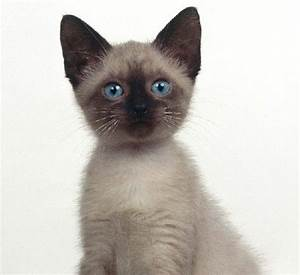

In [4]:
# Show an image
animals_10['image'][2000]

In [3]:
#########################
## Image Preprocessing ##
#########################

def transform_func(dataset):
    # The processor handles resizing, resizing to 224x224, 
    # and normalizing based on ResNet's requirements.
    inputs = processor(dataset["image"], return_tensors="pt")
    
    # We also need to include the labels in the output
    inputs["labels"] = dataset["label"]
    return inputs

animals_10_processed = animals_10.with_transform(transform_func)

print(animals_10_processed[0])
# {'pixel_values': tensor([[[ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2147,  2.2147],
#          [ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2147,  2.2147],
#          [ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2147,  2.2147],
#          ...,
#          [ 2.1975,  2.1975,  2.1975,  ..., -1.9295, -1.5528, -1.7412],
#          [ 2.1633,  2.1633,  2.1633,  ..., -1.4500, -0.9020, -1.4158],
#          [ 2.1462,  2.1462,  2.1633,  ..., -1.1760, -1.0562, -1.6898]],

#         [[ 2.3936,  2.3936,  2.3936,  ...,  2.3936,  2.3936,  2.3936],
#          [ 2.3936,  2.3936,  2.3936,  ...,  2.3936,  2.3936,  2.3936],
#          [ 2.3936,  2.3936,  2.3936,  ...,  2.3936,  2.3936,  2.3936],
#          ...,
#          [ 2.3936,  2.4111,  2.3936,  ..., -0.6001,  0.1527,  0.1702],
#          [ 2.4111,  2.4111,  2.4111,  ..., -0.0399,  0.8704,  0.5903],
#          [ 2.4111,  2.4111,  2.4111,  ...,  0.2927,  0.7479,  0.3452]],

#         [[ 2.6051,  2.6051,  2.6051,  ...,  2.6051,  2.6051,  2.6051],
#          [ 2.6051,  2.6051,  2.6051,  ...,  2.6051,  2.6051,  2.6051],
#          [ 2.6051,  2.6051,  2.6051,  ...,  2.6051,  2.6051,  2.6051],
#          ...,
#          [ 2.6400,  2.6226,  2.6226,  ...,  0.5485,  1.4025,  1.4548],
#          [ 2.6400,  2.6400,  2.6400,  ...,  1.1062,  2.0823,  1.8383],
#          [ 2.6400,  2.6400,  2.6400,  ...,  1.4374,  1.9428,  1.5768]]]), 'labels': 0}

{'pixel_values': tensor([[[ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2147,  2.2147],
         [ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2147,  2.2147],
         [ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2147,  2.2147],
         ...,
         [ 2.1975,  2.1975,  2.1975,  ..., -1.9295, -1.5528, -1.7412],
         [ 2.1633,  2.1633,  2.1633,  ..., -1.4500, -0.9020, -1.4158],
         [ 2.1462,  2.1462,  2.1633,  ..., -1.1760, -1.0562, -1.6898]],

        [[ 2.3936,  2.3936,  2.3936,  ...,  2.3936,  2.3936,  2.3936],
         [ 2.3936,  2.3936,  2.3936,  ...,  2.3936,  2.3936,  2.3936],
         [ 2.3936,  2.3936,  2.3936,  ...,  2.3936,  2.3936,  2.3936],
         ...,
         [ 2.3936,  2.4111,  2.3936,  ..., -0.6001,  0.1527,  0.1702],
         [ 2.4111,  2.4111,  2.4111,  ..., -0.0399,  0.8704,  0.5903],
         [ 2.4111,  2.4111,  2.4111,  ...,  0.2927,  0.7479,  0.3452]],

        [[ 2.6051,  2.6051,  2.6051,  ...,  2.6051,  2.6051,  2.6051],
         [ 2.6051,  2.6051, 

In [10]:
#######################
## Dataset splitting ##
#######################

train_len = int(0.7 * len(animals_10))
val_len = int(0.15 * len(animals_10))
test_len = len(animals_10) - (train_len + val_len)

from torch.utils.data import DataLoader, random_split

train_split, val_split, test_split = random_split(
    dataset=animals_10_processed, 
    lengths=[train_len, val_len, test_len]
)

#-----
## Custom collate function
#-----

def collate_fn(batch):
    """Properly batch the transformed data"""
    pixel_values = torch.stack([item["pixel_values"].squeeze(0) for item in batch])
    labels = torch.tensor([item["labels"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

#-----
## Train - Val - Test loader
#-----

BATCH_SIZE = 48

train_set = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_set = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_set = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [14]:
##########################
## ResNet50 fine-tuning ##
##########################

#-----
## Get pretrained model
#----

from transformers import ResNetForImageClassification

model = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=10,  # Animals-10 has 10 classes
    ignore_mismatched_sizes=True  # This allows changing the classification head
)

import torch
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([10, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
#-----
## Loss - Optimizer - Scheduler
#----

from torch import nn

loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5)

#-----
## Freeze other layers, only train the classifier head
#----

for param in model.resnet.parameters():
    param.requires_grad = False

optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=0.0001)

In [18]:
################################
## Training - Validating loop ##
################################

epochs = 50
train_loss_list, val_loss_list = [], []

for epoch in tqdm(range(1, epochs+1), desc="Training"):
    # --- TRAINING ---
    _ = model.train()
    train_loss = 0    
    for batch in train_set:  # FIXED: Remove enumerate()
        # Move values to device
        images = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        outputs = model(images)
        preds = outputs.logits  # FIXED: Access .logits
        loss = loss_fn(preds, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_set)  # FIXED: Average train loss
    
    # --- VALIDATION ---
    _ = model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for batch in val_set:  # FIXED: Remove enumerate()
            # Move values to device
            images = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            outputs = model(images)
            val_preds = outputs.logits  # FIXED: Access .logits
            
            # Accumulate loss
            val_loss += loss_fn(val_preds, labels).item()
            
            # Calculate accuracy
            total += labels.size(0)
            predicted = torch.argmax(val_preds, dim=1)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_set)
    avg_val_acc = 100 * (correct / total)
    
    train_loss_list.append(avg_train_loss)  # FIXED: Append average
    val_loss_list.append(avg_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    
    if (epoch % 10 == 0) or (epoch == 1):
        tqdm.write("+" * 50)
        tqdm.write(f"Epoch: {epoch}")
        tqdm.write(f"Train loss: {avg_train_loss:.4f}")  # FIXED: Use average
        tqdm.write(f"Validation loss: {avg_val_loss:.4f}")
        tqdm.write(f"Validation accuracy: {avg_val_acc:.2f}%")
        tqdm.write(f"Current LR: {current_lr}")

Training:   2%|██▉                                                                                                                                                 | 1/50 [00:54<44:25, 54.39s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 1
Train loss: 1.8237
Validation loss: 1.5000
Validation accuracy: 68.41%
Current LR: 0.0001


Training:  20%|█████████████████████████████▍                                                                                                                     | 10/50 [09:02<36:14, 54.37s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 10
Train loss: 0.2767
Validation loss: 0.2665
Validation accuracy: 95.75%
Current LR: 0.0001


Training:  40%|██████████████████████████████████████████████████████████▊                                                                                        | 20/50 [18:07<27:14, 54.47s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20
Train loss: 0.1561
Validation loss: 0.1477
Validation accuracy: 96.86%
Current LR: 0.0001


Training:  60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 30/50 [27:11<18:09, 54.50s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 30
Train loss: 0.1156
Validation loss: 0.1202
Validation accuracy: 97.03%
Current LR: 0.0001


Training:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 40/50 [36:16<09:03, 54.40s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 40
Train loss: 0.0989
Validation loss: 0.1043
Validation accuracy: 97.45%
Current LR: 0.0001


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [45:20<00:00, 54.40s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 50
Train loss: 0.0852
Validation loss: 0.0925
Validation accuracy: 97.79%
Current LR: 0.0001


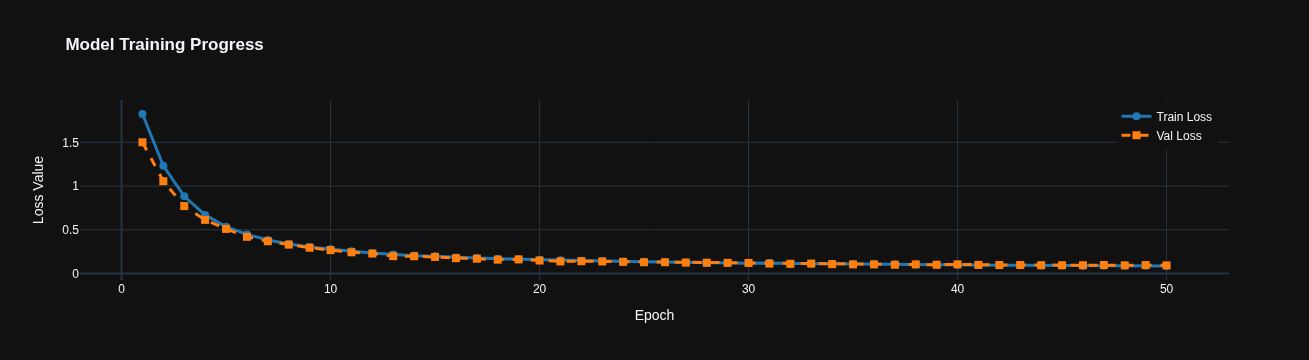

In [19]:
#######################################
## Drawing Train and Val loss curves ##
#######################################

def plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list):
    import plotly.graph_objects as pgo
    import numpy as np
    
    # 1. Define the X-axis (epochs)
    epoch_axis = np.arange(1, epochs + 1, 1)

    fig = pgo.Figure()

    # 2. Add Training Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=train_loss_list,
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=8)
    ))

    # 3. Add Validation Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=val_loss_list,
        mode='lines+markers',
        name='Val Loss',
        line=dict(color='#ff7f0e', width=3, dash='dash'),
        marker=dict(size=8, symbol='square')
    ))

    # 4. Layout & Styling
    fig.update_layout(
        title='<b>Model Training Progress</b>',
        xaxis_title='Epoch',
        yaxis_title='Loss Value',
        template='plotly_dark', # Clean dark background
        hovermode='x unified',   # Shows both values on hover
        legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
    )

    fig.show()
    
plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list)

Classification report
               precision    recall  f1-score   support

   Butterfly       0.99      0.96      0.97       239
         Cat       0.98      0.98      0.98       168
     Chicken       0.99      0.98      0.98       449
         Cow       0.92      0.90      0.91       292
         Dog       0.98      0.97      0.98       743
    Elephant       0.98      0.96      0.97       158
       Horse       0.94      0.95      0.95       371
       Sheep       0.92      0.93      0.93       213
      Spider       0.98      1.00      0.99       651
    Squirrel       0.98      0.99      0.99       250

    accuracy                           0.97      3534
   macro avg       0.97      0.96      0.96      3534
weighted avg       0.97      0.97      0.97      3534



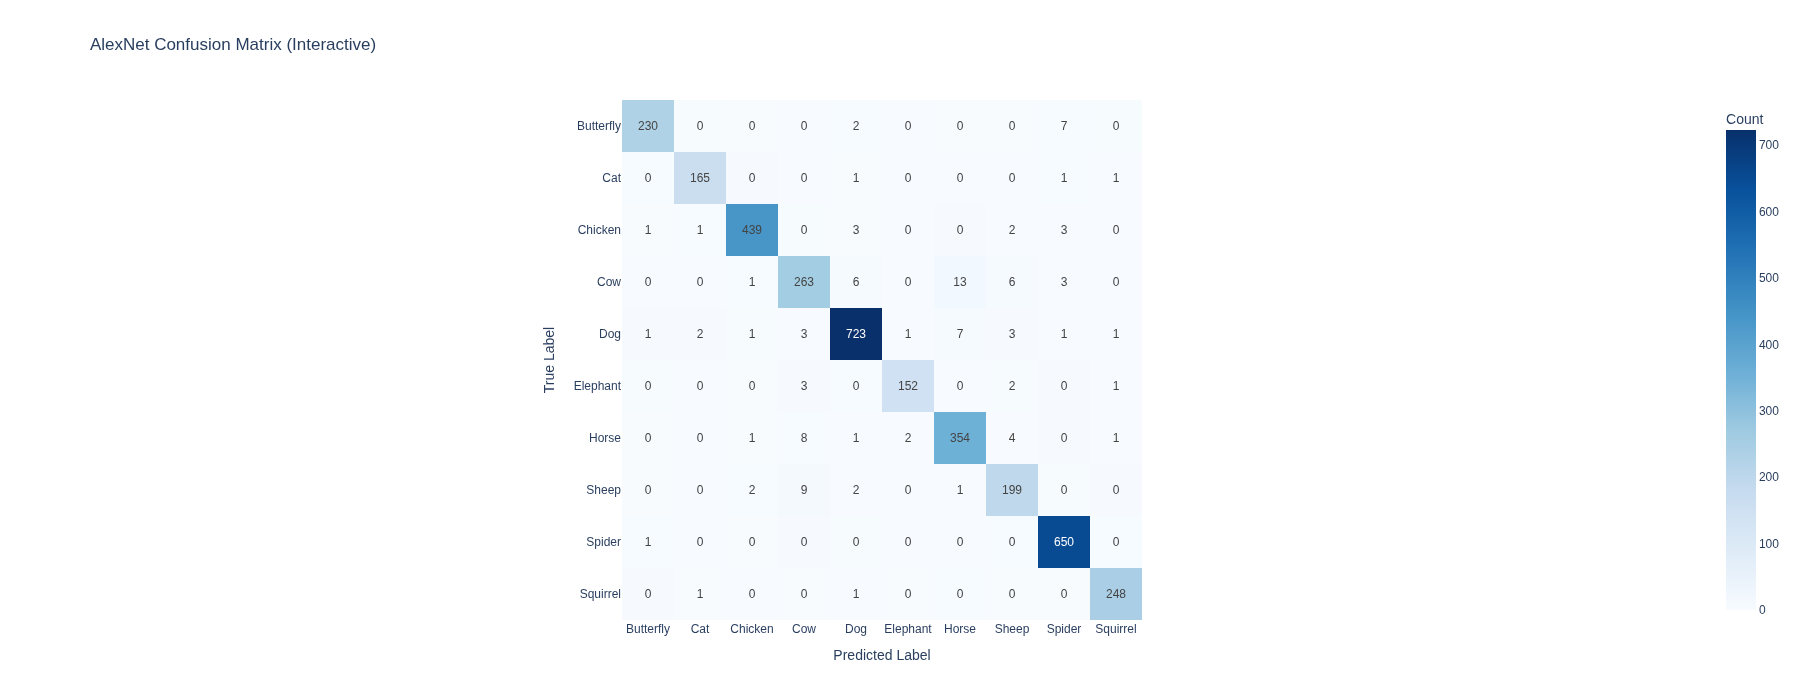

In [38]:
#############
## Testing ##
#############

class_names = animals_10.features['label'].names

from sklearn.metrics import confusion_matrix, classification_report

# 1. Put model in eval mode
_ = model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for batch in test_set:  # FIXED: Remove enumerate()
        # Move values to device
        images = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
    
        outputs = model(images)
        preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2. Generate the raw confusion matrix array
cm = confusion_matrix(all_labels, all_preds)

# 3. Print classification report
print('Classification report\n', classification_report(y_true=all_labels, y_pred=all_preds, target_names=class_names))
# Classification report
#                precision    recall  f1-score   support

#    Butterfly       0.99      0.96      0.97       239
#          Cat       0.98      0.98      0.98       168
#      Chicken       0.99      0.98      0.98       449
#          Cow       0.92      0.90      0.91       292
#          Dog       0.98      0.97      0.98       743
#     Elephant       0.98      0.96      0.97       158
#        Horse       0.94      0.95      0.95       371
#        Sheep       0.92      0.93      0.93       213
#       Spider       0.98      1.00      0.99       651
#     Squirrel       0.98      0.99      0.99       250

#     accuracy                           0.97      3534
#    macro avg       0.97      0.96      0.96      3534
# weighted avg       0.97      0.97      0.97      3534

#----------
## Visualize confusion matrix
#----------
        
import plotly.express as px

fig = px.imshow(
    cm,
    text_auto=True,               # Shows the numbers inside the squares
    labels=dict(x="Predicted", y="Actual", color="Count"),
    x=class_names,
    y=class_names,
    color_continuous_scale='Blues',
    title='AlexNet Confusion Matrix (Interactive)'
)

fig.update_layout(
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    width=700,
    height=700
)

fig.show()

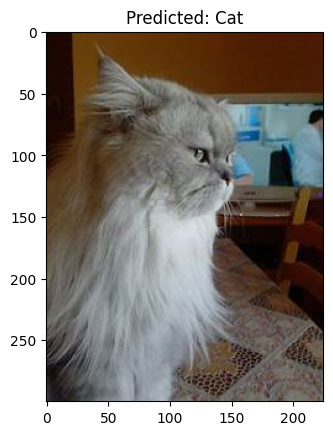

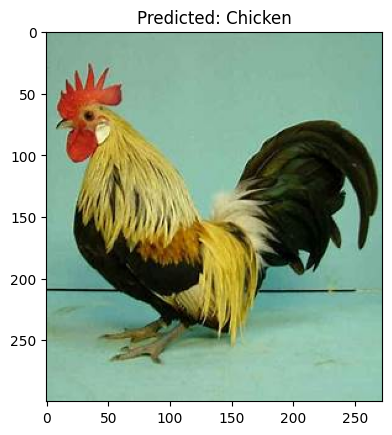

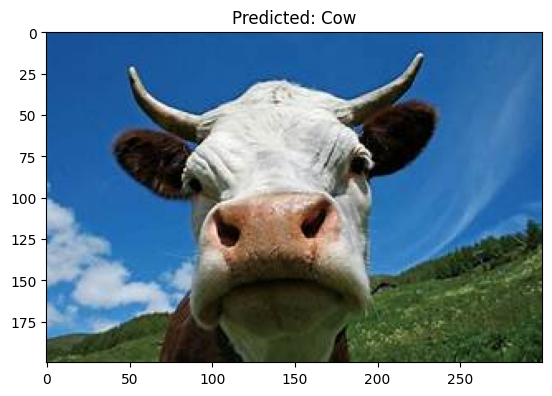

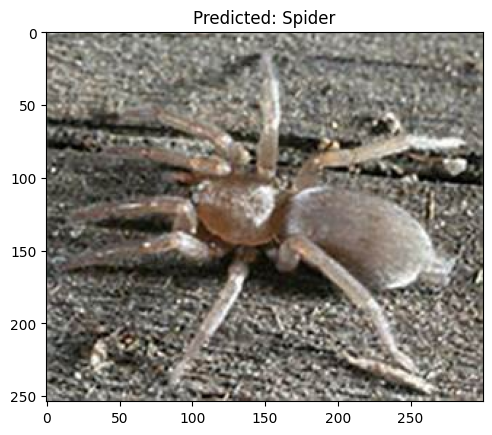

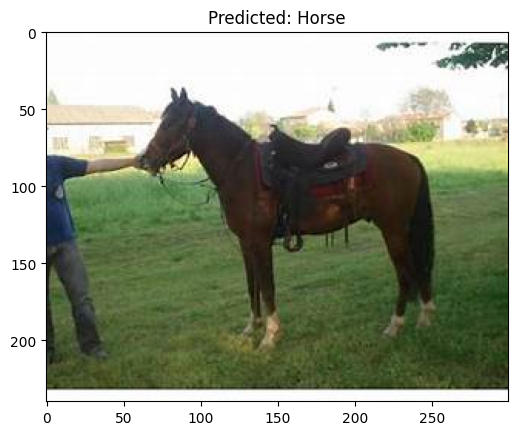

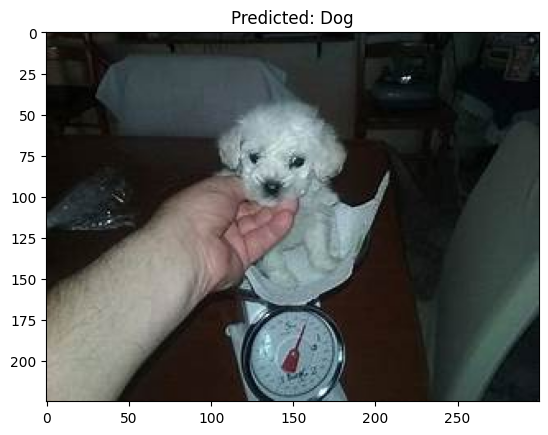

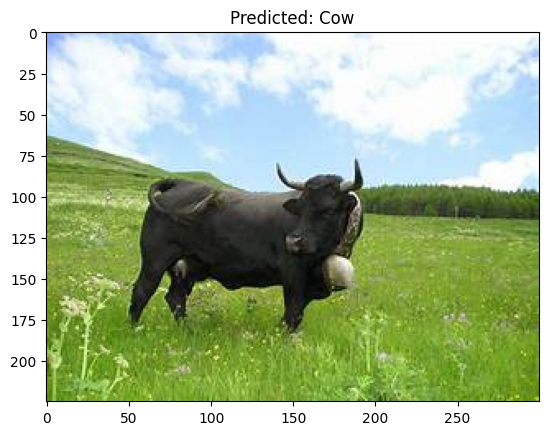

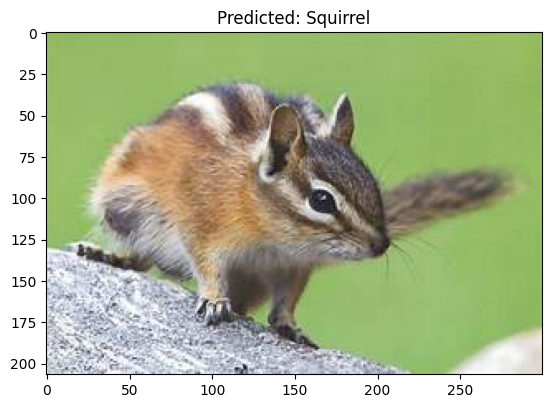

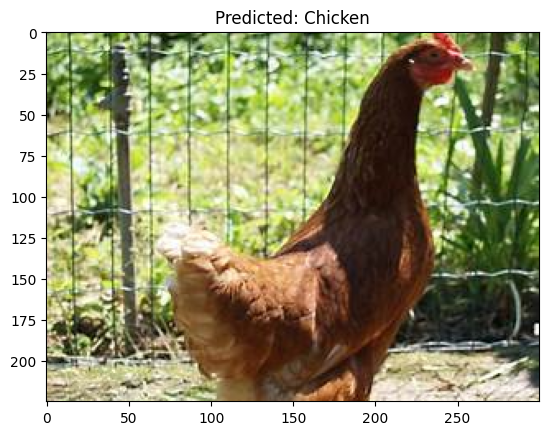

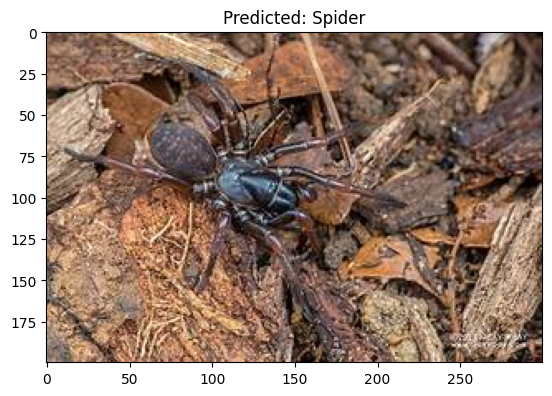

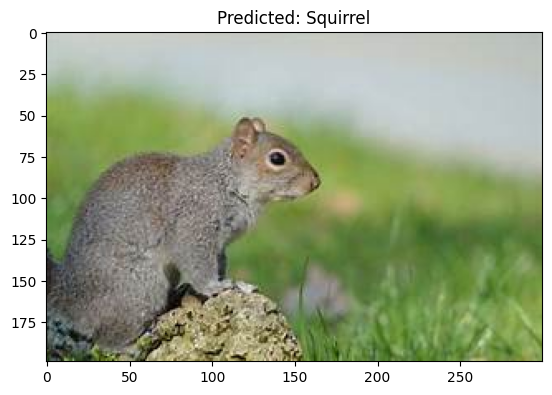

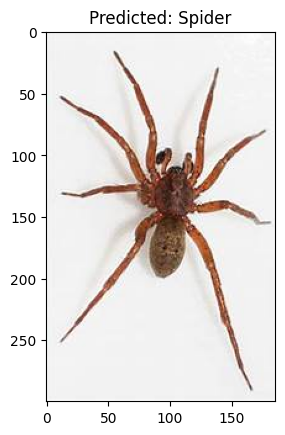

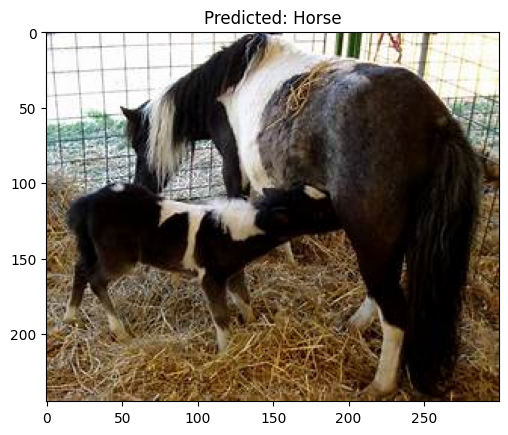

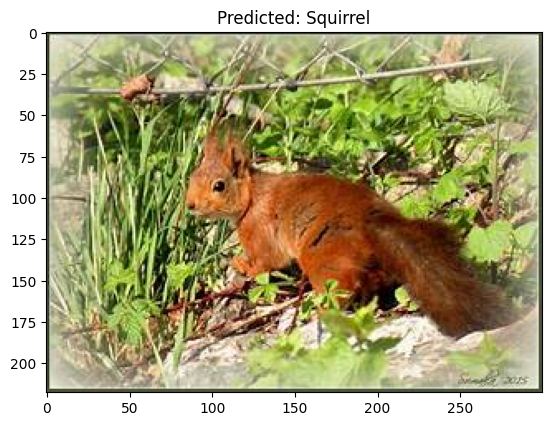

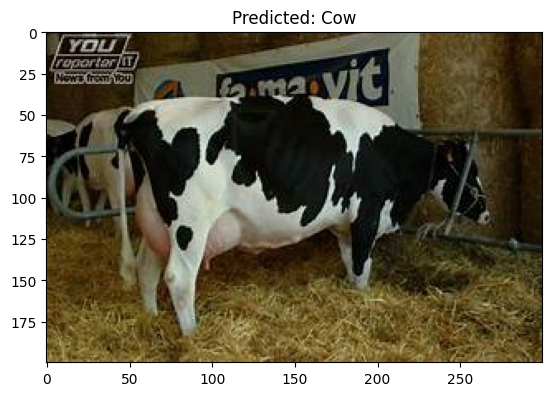

In [40]:
#----------
## Visualize some random predicted images (test_set)
#----------

import numpy as np

np.random.seed(42)
idx_random = np.random.randint(0, test_len+1, 15)

import matplotlib.pyplot as plt

for i in idx_random:
    print("="*50)
    idx_original = test_split.indices[i]
    image = animals_10['image'][idx_original]
    predict_class = animals_10.features['label'].names[all_preds[i]]
    plt.title(f"Predicted: {predict_class}")
    plt.imshow(image)
    plt.show()

In [44]:
########################
## Saving whole model ##
########################

# import os
# os.chdir('../')
# os.getcwd() # '/home/longdpt/Documents/Long_AISDL/DeepLearning_PyTorch'

from pathlib import Path

MODEL_PATH = Path("04_CNN").joinpath("save")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# PyTorch model can be saved in .pth or .pt format
PARAMS_NAME = "ResNet50_tuned_model.pth"

# Save the model (use model.state_dict() to save only the parameters)
torch.save(obj=model, f=MODEL_PATH.joinpath(PARAMS_NAME))